## Implied Volatility (IV)
In financial mathematics, IV of an options contract is value of volatility of the underlying instrument that, when put into options model, returns theoretical value equal to current market price. Black-Scholes Merton Model: 
$C(S_t,K,t,T,r,\sigma^{imp}) = S_t N(d_1) - e^{-r(T-t)}*K*N(d_2)$ where $N(d) = \frac{1}{\sqrt{2\pi}} 
\int_{-\infty}^{d} e^{-\frac{1}{2}x^2}dx$, $d_1=\frac{log(\frac{S_t}{k})+(r+\frac{\sigma^2}{2})(T-t)}{\sigma \sqrt{T-t}}$ and $d_2 = \frac{log(\frac{S_t}{k})+(r-\frac{\sigma^2}{2})(T-t)}{\sigma \sqrt{T-t}}$

$C(S,K,t,T,r,\sigma^{imp}) = C^*$. $S$ is the price at time $t$. $\sigma$ is constant volatility. $K$ is the 
strike price of option. $T$ is the maturity of option. $r$ is constant riskless short rate.

No closed-form solution - need to use numerical procedure - Newton's Method

Average true range (ATR) can give an idea of volatility. To compare between stocks of different prices, we have \% ATR, \% volatility measure.

ATR indices can be added to plots. We take ATR/Price of Stock. Then comparisons of volatilities can be made simpler.

$\sigma_{n+1}^{imp} = \sigma_{n}^{imp} - \frac{C(\sigma_n^{imp})-C^*}{\frac{\partial C(\sigma_n^{imp})}
{\partial \sigma_n^{imp}}}$. We initialize the Newton process with $\sigma_{0}^{imp}$ and finite $n$.

Partial derivative of the volatility is called *Vega*. Vega of an option in the BSM model: $\frac{\partial C}{\partial \sigma} = S_t N(d_1)\sqrt{T-t}$


VSTOXX - volatility index

Black Scholes Merton model assumes that the price of a stock follows brownian motion. This is a continuous-time stochastic process where log of varying quantity follows brownian motion (random movement of particles in liquid or gas) with drift. Mathematically, brownian motion is described by the Weiner process. $W_0=0,W_t$ continuous, $W_t-W_s \sim N(0,t-s)$

$\frac{dS}{S} = \mu dt + \sigma dW$. $W$ is the stochastic variable following brownian motion 

In [1]:
#conda create --name myenv
#conda activate myenv
#ipython kernel install --user --name=myenv

In [13]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy
import tables
import h5py
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline


In [14]:
import pandas_datareader.data as web
import plotly.graph_objects as go
import seaborn
import nbformat

In [15]:
hdf = pd.HDFStore('./vstoxx_data_31032014.h5', 'r')

In [16]:
futures_data = hdf["futures_data"]
options_data = hdf['options_data']

In [17]:
hdf.close()

In [18]:
options_data["IMPLIED_VOLATILITY"] = 0

In [19]:
# employing Newton's Method - assuming t = 0
class ImpliedVolatility:
    def __init__(self,S0,K,T,r,sigma):
        self.S0 = float(S0)
        self.K = float(K)
        self.T = float(T)
        self.r = float(r)
        self.sigma = float(sigma)
    def getD1(self,sigma):
        return (np.log(self.S0/self.K)+(self.r+((sigma**2)/2))*(self.T))/(sigma*(np.sqrt(self.T))) 
    def _callValue(self,sigma):
        d1 = self.getD1(sigma) 
        d2 = (np.log(self.S0/self.K)+(self.r-((sigma**2)/2))*(self.T))/(sigma*(np.sqrt(self.T)))
        firstVal = self.S0*scipy.stats.norm.cdf(d1)
        secondVal = np.exp(-self.r*self.T)*self.K*scipy.stats.norm.cdf(d2)
        return firstVal-secondVal
    def _vega(self,sigma):
        d1 = self.getD1(sigma)
        return (self.S0)*scipy.stats.norm.cdf(d1)*(np.sqrt(self.T))                                              
    def _newtonMethod(self,C0,iterations=100):
        sigmaCurr = self.sigma
        for i in range(iterations):
            sigmaCurr -= (self._callValue(sigmaCurr)-C0)/(self._vega(sigmaCurr))
        return sigmaCurr

In [20]:
V0 = 17.6639
r = 0.01
tolerance = 0.5
for i in options_data.index:
    # strike price is fixed price at which an option can be sold/bought
    # looking for options within tolerance range
    first = futures_data[futures_data['MATURITY']==options_data.loc[i]['MATURITY']]["PRICE"].values[0]
    if (first*(1-tolerance) < options_data.loc[i]["STRIKE"] < first*(1+tolerance)):
        impVol = ImpliedVolatility(V0,
                                   options_data.loc[i]["STRIKE"],
                                   options_data.loc[i]["TTM"],
                                   r,
                                   2)
        options_data["IMPLIED_VOLATILITY"].loc[i] = impVol._newtonMethod(options_data.loc[i]["PRICE"])
options_data.head()

/Users/dylanc_home/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM,IMPLIED_VOLATILITY
46170,2014-03-31,2014,4,C,1.0,16.85,2014-04-18,0.049,0.0
46171,2014-03-31,2014,4,C,2.0,15.85,2014-04-18,0.049,0.0
46172,2014-03-31,2014,4,C,3.0,14.85,2014-04-18,0.049,0.0
46173,2014-03-31,2014,4,C,4.0,13.85,2014-04-18,0.049,0.0
46174,2014-03-31,2014,4,C,5.0,12.85,2014-04-18,0.049,0.0


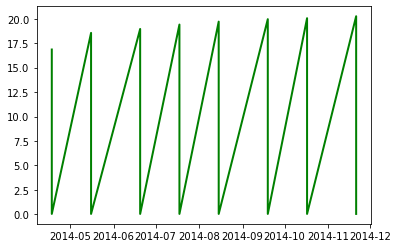

In [22]:
plt.plot(options_data["MATURITY"],options_data["PRICE"],lw=2,color='g')

In [23]:
plot_data = options_data[options_data["IMPLIED_VOLATILITY"] > 0]

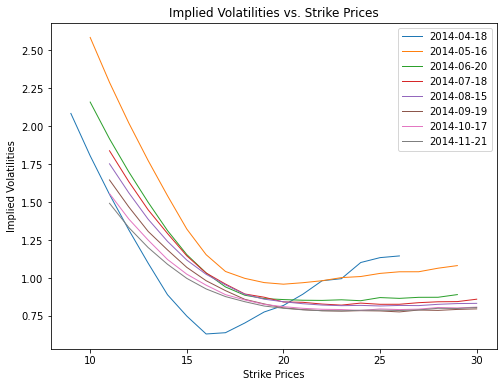

In [24]:
plt.figure(figsize=(8,6))
maturities = sorted(set(plot_data["MATURITY"]))
for maturity in maturities:
    subset = plot_data[plot_data["MATURITY"] == maturity]
    plt.plot(subset["STRIKE"],subset["IMPLIED_VOLATILITY"],label=maturity.date(),lw=1)
plt.xlabel("Strike Prices")
plt.ylabel("Implied Volatilities")
plt.title("Implied Volatilities vs. Strike Prices")
plt.legend()
plt.show()
# VSTOXX from 2014

## Monte Carlo Simulation

Important for simulations and options pricing. MC can cope with higher dimensions but the issue comes from computational complexity. BSM differential equation: $dS_t = rS_td_t + \sigma S_t d Z_t$. The euler discretization of the stochastic differential equation: $S_t = S_{t-\triangle t} exp((r-\frac{1}{2}\sigma^2)\triangle t+\sigma \sqrt{\triangle t z_t})$. 
$C_0 \approx e^{-rT} \frac{1}{I} \sum\limits_{I} h_T(S_T(i))$. We'll use vectorization in Numpy. Numpy is implemented with C, which is fast.

In [25]:
%%time
np.random.seed(20000)
class MCSimulation:
    def __init__(self,S0,K,T,r,sigma):
        self.S0=S0
        self.K=K
        self.T=T
        self.r=r
        self.sigma=sigma
    # going through M time steps - using vectors
    def simulate(self,paths=250000,time_steps=50):
        # each row is a time step. We add one since first row is the initialized state.
        mat = np.zeros((time_steps+1,paths))
        changeInTime = self.T/time_steps
        mat[0] = self.S0
        for t in range(1,time_steps+1):
            r = np.random.normal(size=paths)
            mat[t] = mat[t-1]*np.exp((self.r-(0.5*self.sigma**2))*changeInTime+\
                     self.sigma*(np.sqrt(changeInTime)*r))
        # h_T(S_T(i)) = max(S_T-K,0)
        est = np.exp(-self.r*self.T)*(1/paths)*np.sum(np.maximum(mat[time_steps]-self.K,0))
        return (mat,est)
monteCarloVStoxx = MCSimulation(100,105,1,0.05,0.2)
mat,estC = monteCarloVStoxx.simulate()


CPU times: user 361 ms, sys: 24.2 ms, total: 385 ms
Wall time: 384 ms


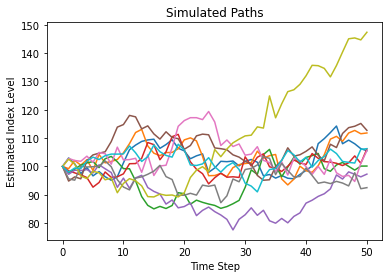

In [26]:
simulPaths = plt.plot(mat[:,:10])
plt.title("Simulated Paths")
plt.xlabel("Time Step")
plt.ylabel("Estimated Index Level")
plt.show()

In [27]:
sp500 = web.DataReader('^GSPC', data_source='yahoo', start='1/1/2020', end='1/1/2021')

In [28]:
alphabet = web.DataReader("GOOG",data_source='yahoo',start='1/1/2020', end='1/1/2021')

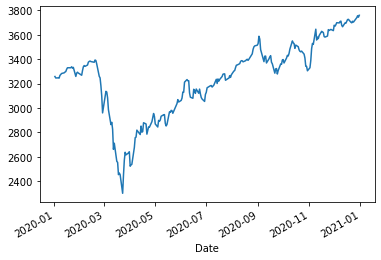

In [29]:
sp500_2020graph = sp500['High'].plot()

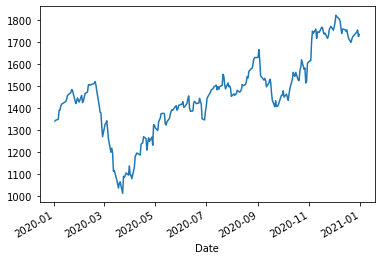

In [30]:
alphabet_2020graph = alphabet['Low'].plot()

In [31]:
alphabet.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2020-01-02 to 2020-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       253 non-null    float64
 1   Low        253 non-null    float64
 2   Open       253 non-null    float64
 3   Close      253 non-null    float64
 4   Volume     253 non-null    int64  
 5   Adj Close  253 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 13.8 KB


**Because the price of a stock moves according to brownian motion, we write the corresponding exponential relation:** $S_T = S_0 e^{(\mu-\frac{1}{2}\sigma^2)T + \sigma W_T}$. 

## Another way to measure volality comes from visualization. Here we can use candlestick plots. 

In [37]:
fig = go.Figure(data=[go.Candlestick(x=alphabet.index,
                open=alphabet['Open'],
                high=alphabet['High'],
                low=alphabet['Low'],
                close=alphabet['Close'])])
fig.update_layout(title="Alphabet's Stock during 2020",
                  yaxis_title='GOOG Stock',
                  xaxis_title="Dates")
fig.show()